In [2]:
using DifferentialEquations
using Plots; gr()
using IntervalArithmetic
using DataInterpolations
using LinearAlgebra
using ForwardDiff

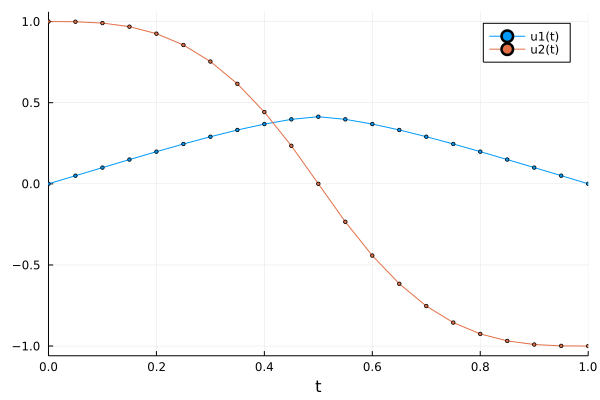

Numericky získané první vlastní číslo λ₁: 28.28876197305467
Chyba proti přesnému řešení: 2.9478819385531096e-9


In [20]:
## nastavení p a přesná hodnota λ₁
P=3
λ1 = (P-1)*(2*(π/P)/(sin(π/P)))^P

# nastavení základních parametrů
tn = 21 # kroků dělení
xn = 2002 # dělení jednotlivého oblouku spline

α = 0.001 # kolik budeme přičítat k řešení

a,b = (3.,40.); # interval na kterém hledá λ₁ (nesmí obsahovat i λ₂, jinak to můž najít to)


# řešení diferenciální soustavy metodou střelby

function sl(du,u,p,t) # parametr p je odhad na λ₁ a p z p-laplacianu
    λ, r = p
    du[1] = abs(u[2])^(1/(r-1)) * sign(u[2])
	du[2] = -λ * abs(u[1])^(r-1)*sign(u[1]) # abs mohu pro u₁ vynechat, protože je vždy kladné
end

u0 = [0.0; 1.0;] # počáteční podmínka

s = (a + b)/2
ts = 1.0/(tn-1) # velikost intervalu dělení


e = 1e-12 # zastavovací podmínka

while (b-a) >= e
    prob = ODEProblem(sl, u0, (0.0, 1.0), (s, P))
    sol = solve(prob, saveat=ts, abstol=1e-8,reltol=1e-8)

    if sol(1)[1] == 0 # bere hodnotu v t=1 (pravej konec) pro první řešení soustavy u₁
        break
    else
        probA = ODEProblem(sl, u0, (0.0, 1.0), (a, P))
        solA = solve(probA, saveat=ts, abstol=1e-8,reltol=1e-8)
        
        probS = ODEProblem(sl, u0, (0.0, 1.0), (s, P))
        solS = solve(probS, saveat=ts, abstol=1e-8,reltol=1e-8)

        if solA(1)[1] * solS(1)[1] < 0
            b = s
        else
            a = s
        end
        s = (a+b)/2
    end
end
    
prob = ODEProblem(sl, u0, (0.0, 1.0), (s, P))
sol = solve(prob, saveat=ts, abstol=1e-8,reltol=1e-8)

println("Numericky získané první vlastní číslo λ₁: $s")
println("Chyba proti přesnému řešení: $(λ1-s)")
display(plot(sol,marker=2))

t = sol.t
ti = [@interval(i) for i in t]

u2 = [u[2] for u in sol.u]
u2i = [@interval(u[2]) for u in sol.u];

In [21]:
println(10*(P-1)*α*s)

println((P-1) * α^(P-2) * λ1)
println((P-1) * @interval(α)^(P-2) * @interval(λ1))

δ = (P-1) * α^(P-2) * λ1

0.5657752394610934
0.056577523952005104
[0.0565775, 0.0565776]


0.056577523952005104

Minimium na konci ( d2=-0.025, u1_min=[2.74201e-13, 5.23952e-05]: [27.9644, 28.0088]  [chyba: 0.32434072748763754]
Minimium na konci ( d2=-0.024482758620689656, u1_min=[2.74201e-13, 5.23952e-05]: [27.9659, 28.0088]  [chyba: 0.322826560355157]
Minimium na konci ( d2=-0.02396551724137931, u1_min=[2.74201e-13, 5.23952e-05]: [27.9673, 28.0088]  [chyba: 0.32136785251702804]
Minimium na konci ( d2=-0.023448275862068966, u1_min=[2.74201e-13, 5.23952e-05]: [27.9687, 28.0088]  [chyba: 0.3199689971339268]
Minimium na konci ( d2=-0.02293103448275862, u1_min=[2.74201e-13, 5.23952e-05]: [27.9701, 28.0088]  [chyba: 0.31863510380420834]
Minimium na konci ( d2=-0.022413793103448276, u1_min=[2.74201e-13, 5.23952e-05]: [27.9713, 28.0088]  [chyba: 0.31737155967175923]
Minimium na konci ( d2=-0.02189655172413793, u1_min=[2.742e-13, 5.23952e-05]: [27.9725, 28.0088]  [chyba: 0.3161847391557693]
Minimium na konci ( d2=-0.021379310344827585, u1_min=[2.742e-13, 5.23952e-05]: [27.9736, 28.0088]  [chyba: 0.31508

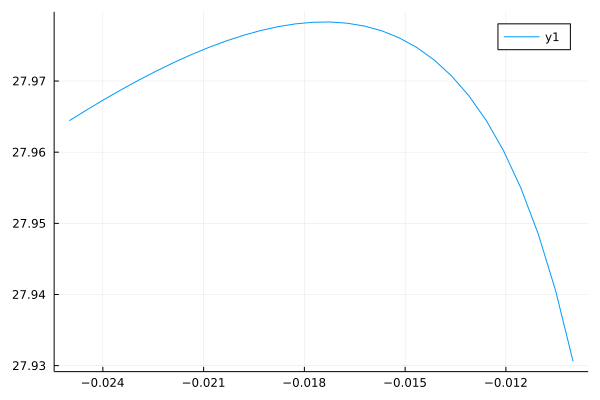

In [24]:
rrr = range(-0.025, -0.010, length=30)#-0.2:.1:0 # 9.988 finální hodnota pro levou stranu
#rrr = range(10.125, 10.137, length=15)#-0.2:.1:0 # 10.131 finalní hodnota pro pravou stranu
#rrr = range(-0.038, -0.031, length=15)

vals = []

for d2val_1 in rrr #[-0.1, -0.2, -0.5, -0.8, -1.0, -1.2, -1.5, -2.0, -3.0, -5.0]
    
    ### proložení u2 kubickým splinem
    #matice A
    n=length(u2i)
    dv = [4 for i in 1:n-2]
    ev = [1 for i in 1:n-3]
    A = Array(SymTridiagonal(dv,ev))
    A_inv = inv(A) #inverze

    #pravá strana
    h = ts
    # sestavení pravé strany
    rhs = []
    for i in 3:length(u2i)
        append!(rhs, 6/h^2 * (u2i[i] - 2 * u2i[i-1] + u2i[i-2]))
    end

    # vypočte vektor druhých derivací potřebný na výpočet koeficientů
    # druhá derivace na krajích je nastavena na -1

    d2v = []
    append!(d2v, @interval(-d2val_1)) # druhou derivaci nastavíme na přihbližnou hodnotu λ₁
    append!(d2v, A_inv*rhs)
    append!(d2v, @interval(d2val_1)) #d2val_1));

    # výpočet koeficientů jednotlivých oblouků splinu
    csc_u2 = [] #@interval zeros(4, length(solu)-1)
    for i in 1:length(u2i)-1
        a=b=c=d=0
        a = (d2v[i+1]-d2v[i])/(6*h)
        b = d2v[i]/2 
        c = (u2i[i+1] - u2i[i])/h - h*(2*d2v[i]+d2v[i+1])/6
        d = u2i[i]
        append!(csc_u2, [[a,b,c,d]])
        #csc[1, i] = a
    end
    
    ### napočítání hodnot spline u2
    #p = plot(t,u2, marker=2)
    u2spl = Interval[]
    for i in 1:length(u2i)-1
        x_dom = t[i]..t[i+1] # domain # range(0,1,length=n)
        x_int = mince(x_dom,xn)
        f(x) = csc_u2[i][1]*(x-ti[i])^3 + csc_u2[i][2]*(x-ti[i])^2 + csc_u2[i][3]*(x-ti[i]) + csc_u2[i][4]
        append!(u2spl, f.(x_int))
        #boxes = IntervalBox.(x_int, f.(x_int))    
        #plot!(boxes, legend=false)
    end

    tints = mince(0..1,(tn-1)*xn) # časové dělení
    #p
  
     ### výpočet u1 z u2
    ff(x) = abs(x)^(1/(P-1))*sign(x)
    #sum(f.(u2spl) .* diam.(tints))

    u1tmp = Interval[0..0]
    for i in 1:length(u2spl)
        append!(u1tmp, u1tmp[end] + ff(u2spl[i]) * diam(tints[i]))
    end

    u1int = Interval[]
    for i in 1:length(u1tmp)-1
        append!(u1int, u1tmp[i] ∪ u1tmp[i+1])
    end

    #u1int = u1int .+ α
    δ = inf(minimum(u1int))
    if δ > 0
        u1int = u1int .- (δ - δ*1e-8)
    else
        u1int = u1int .+ (-δ - δ*1e-8)
    end
    
    ### spočítat derivaci u2spl z koeficientů = p-laplacian
    csc_u2der =[ [@interval(3) * cs[1], @interval(2) * cs[2], cs[3]] for cs in csc_u2 ]
    
    
    
    ### napočítat čitatele
    numer = Interval[]

    for i in 1:length(u2i)-1
        x_dom = t[i]..t[i+1] # domain # range(0,1,length=n)
        x_int = mince(x_dom,xn)
        f(x) = -(csc_u2der[i][1]*(x-ti[i])^2 + csc_u2der[i][2]*(x-ti[i]) + csc_u2der[i][3])
        append!(numer, f.(x_int))
    end
    
    ### vypočítat hodnotu picone
    
    fff(x,y) = x / y^(P-1)
    picone = fff.(numer, u1int)
    
    #println("Minimium na začátku: $(minimum(picone[1:100]))")
    println("Minimium na konci ( d2=$(d2val_1), u1_min=$(minimum(u1int)): $(minimum(picone[2000:end]))  [chyba: $(λ1-inf(minimum(picone[2000:end])))]") 
    #println("Minimium na začátku ( d2=$(d2val_1), u1_min=$(minimum(u1int)): $(minimum(picone[1:2000])) [chyba: $(λ1-inf(minimum(picone[1:2000])))]") 
    append!(vals, inf(minimum(picone[2000:end])))
    #append!(vals, inf(minimum(picone[1:2000])))
  
    
    #println("HOTOVO")
end

#plot( -1.4:0.01:-1.3, vals)
plot(rrr, vals)


In [163]:
α

0.00010000000000000091

Pravej konec,

Minimium na konci ( d2=-2, u1_min=[9.89994e-05, 0.000102]: [7.00816, 7.06226]
Minimium na konci ( d2=-1, u1_min=[9.89994e-05, 0.000102]: [7.13617, 7.19205]
Minimium na konci ( d2=0, u1_min=[9.89993e-05, 0.000102]: [7.25091, 7.27263]
Minimium na konci ( d2=1, u1_min=[9.89993e-05, 0.000102]: [7.25091, 7.27263]
Minimium na konci ( d2=2, u1_min=[9.89993e-05, 0.000102]: [7.25091, 7.27263]
Minimium na konci ( d2=3, u1_min=[9.89992e-05, 0.000102]: [7.25091, 7.27263]
Minimium na konci ( d2=4, u1_min=[9.89992e-05, 0.000102]: [7.25091, 7.27263]
Minimium na konci ( d2=5, u1_min=[9.89991e-05, 0.000102]: [7.25091, 7.27263]
Minimium na konci ( d2=6, u1_min=[9.89991e-05, 0.000102]: [7.19606, 7.27263]
Minimium na konci ( d2=7, u1_min=[9.8999e-05, 0.000102]: [5.0027, 5.33622]
Minimium na konci ( d2=8, u1_min=[9.8999e-05, 0.000102]: [1.7445, 1.96918]
Minimium na konci ( d2=9, u1_min=[9.8999e-05, 0.000102]: [-1.55959, -1.35674]
Minimium na konci ( d2=10, u1_min=[9.89989e-05, 0.000102]: [-4.91654, -4.62474]

In [ ]:
### spočítat derivaci u2spl z koeficientů = p-laplacian
    csc_u2der =[ [@interval(3) * cs[1], @interval(2) * cs[2], cs[3]] for cs in csc_u2 ]
    
    
    
    ### napočítat čitatele
    numer = Interval[]

    for i in 1:length(u2i)-1
        x_dom = t[i]..t[i+1] # domain # range(0,1,length=n)
        x_int = mince(x_dom,xn)
        f(x) = -(csc_u2der[i][1]*(x-ti[i])^2 + csc_u2der[i][2]*(x-ti[i]) + csc_u2der[i][3])
        append!(numer, f.(x_int))
    end
    
    ### vypočítat hodnotu picone
    
    f(x,y) = x / y^(P-1)
    picone = f.(numer, u1int)
    
    #println("Minimium na začátku: $(minimum(picone[1:100]))")
    println("Minimium na konci ( d2=$(d2val_1) ): $(minimum(picone[320:end]))")    

In [15]:
for i in -1.8:0.1:-1.2
    println(i)
end

-1.8
-1.7
-1.6
-1.5
-1.4
-1.3
-1.2


In [ ]:
Minimium na konci ( d2=-1.4 ): [5.11711, 18.5111]
Minimium na konci ( d2=-1.39 ): [5.11856, 18.5454]
Minimium na konci ( d2=-1.38 ): [5.12001, 18.5796]
Minimium na konci ( d2=-1.37 ): [5.12146, 18.6139]
Minimium na konci ( d2=-1.36 ): [5.12291, 18.6481]
Minimium na konci ( d2=-1.35 ): [5.1189, 18.6824]
Minimium na konci ( d2=-1.34 ): [5.10665, 18.7166]
Minimium na konci ( d2=-1.33 ): [5.0944, 18.7509]
Minimium na konci ( d2=-1.32 ): [5.08215, 18.7852]
Minimium na konci ( d2=-1.31 ): [5.0699, 18.8194]
Minimium na konci ( d2=-1.3 ): [5.05765, 18.8537]